In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../bin/imports.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_values_from_df(df):
    values = []
    for a in df.values:
        values.extend(a)
    return values

In [3]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.cancer.TCGA.inclusive.mut.csv',
                 index_col=0)
mutation_counts = pd.DataFrame(df.sum()).reset_index()
mutation_counts.columns = ['mutation', 'count']
driver_mutations = list(mutation_counts[mutation_counts['count'] > 10].mutation)
#driver_mutations = list(mutation_counts.mutation)
print len(driver_mutations)
categories = ['oncogenes', 'tsgenes', 'random0', 'germline', 'viral', 'bacterial']
value_types = []
for category in categories:
    # restrict the columns to higher frequency mutations
    if category == 'oncogenes' or category == 'tsgenes':
        df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.TCGA.inclusive.mut.csv'.format(category),
                         index_col=0)
        #df.set_index('mutation', inplace=True)
        app_restricted_space = [x for x in driver_mutations if x in df.index]
        values = get_values_from_df(df.ix[app_restricted_space, :])
        print category, len(values), len(df.index), len(app_restricted_space)
        value_types.append(values)
    else:
        try:
            df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.TCGA.inclusive.mut.csv'.format(category),
                             index_col=0)
        except:
            df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.all.csv'.format(category),
                             index_col=0)
        #df.set_index('mutation', inplace=True)
        values = get_values_from_df(df)
        value_types.append(values)
        print category, len(values)
categories = ['Oncogenes', 'TSgenes', 'Random', 'Germline', 'Viral', 'Bacterial']
plotting = pd.DataFrame({'category': ['Oncogenes' for x in value_types[0]] + ['TSgenes' for x in value_types[1]] + ['Random' for x in value_types[2]] + ['Germline' for x in value_types[3]] + ['Viral' for x in value_types[4]] + ['Bacterial' for x in value_types[5]],
                         'PHBR': value_types[0] + value_types[1] + value_types[2] + value_types[3] + value_types[4] + value_types[5]})


98
oncogenes 385662 643 51
tsgenes 347852 602 46
random0 7562000
germline 7562000
viral 7290000
bacterial 7290000


In [18]:
# Bootstrapping
categories = ['Oncogenes', 'TSgenes', 'Random', 'Germline', 'Viral', 'Bacterial']
iterations = 100
fraction = {}
for cat in categories:
    fraction[cat] = []
for cat in categories:
    print cat
    tmp = plotting[plotting.category == cat].PHBR
    for i in range(iterations):
        single_trajectory = []
        tmp_boot = tmp.sample(len(tmp), replace = True)
        for x in np.arange(0, 31, 1):
            single_trajectory.append(mean(tmp_boot < x))
        fraction[cat].append(single_trajectory)

In [13]:
# calculate confidence intervals at a cutoff of 6
CI_lb, CI_ub, median = [], [], []
for cat in categories:
    distribution = []
    for i in range(len(fraction[cat])):
        distribution.append(fraction[cat][i][6])
    CI_lb.append(pd.Series(distribution).quantile(0.025))
    median.append(pd.Series(distribution).quantile(0.5))
    CI_ub.append(pd.Series(distribution).quantile(0.975))
results = pd.DataFrame({'Category': categories,
                          'Median': median,
                          'Lower_bound': CI_lb,
                          'Upper_bound': CI_ub})
results.to_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/peptide_comparison/confidence_intervals.threshold_6.iterations_{0}.csv'.format(iterations))

Run bootstrapping on cluster with high iterations

In [23]:
def create_cluster_script_both_classes(iterations):
    
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_analysis/peptide_classes/run_confidence_intervals.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(iterations)))
        out_file.write("#$ -l h_vmem=5G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set iterations=({0})\n".format(" ".join(iterations)))
        out_file.write("\n")

        out_file.write("set iteration=$iterations[$SGE_TASK_ID]\n")
        out_file.write("\n")
        
        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")
  
        out_file.write("python /cellar/users/ramarty/Projects/hla_ii/data_analysis/peptide_classes/confidence_intervals.py " \
                       + "$iteration\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [24]:
create_cluster_script_both_classes(['1000'])

In [ ]:
# with 10 cutoff threshold
plt.figure(figsize=(3.5, 3))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for cat, color in zip(categories, colors):
    for traj in fraction[cat]:
        #print traj[:5]
        plt.plot(np.arange(0, 31, 1), traj, c=color, alpha=0.1)
plt.legend([])
plt.xlim(0, 30)
plt.ylim(0, 0.4)
plt.ylabel('Fraction of residues\nbelow PHBR-II threshold')
plt.xlabel('PHBR-II')
plt.locator_params(axis='y', nbins=6)
L = plt.legend(loc=4, prop={'size': 9})
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/bootstrapping.pdf')

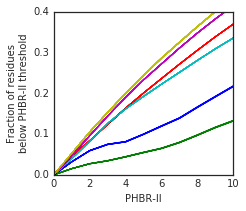

In [31]:
plt.figure(figsize=(3.5, 3))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for cat, color in zip(categories, colors):
    for traj in fraction[cat]:
        #print traj[:5]
        plt.plot(np.arange(0, 31, 1), traj, c=color, alpha=0.1)
plt.legend([])
plt.xlim(0, 10)
plt.ylim(0, 0.4)
plt.ylabel('Fraction of residues\nbelow PHBR-II threshold')
plt.xlabel('PHBR-II')
plt.locator_params(axis='y', nbins=6)
L = plt.legend(loc=4, prop={'size': 9})
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/bootstrapping.zoomed.pdf')

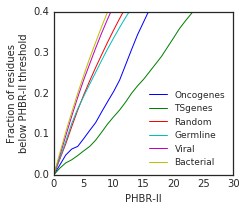

In [10]:
# with 10 cutoff threshold
plt.figure(figsize=(3.5, 3))
for cat in categories:
    plt.plot(np.arange(0, 31, 1), fraction[cat], label=cat)
plt.legend(loc=4)
plt.xlim(0, 30)
plt.ylim(0, 0.4)
plt.ylabel('Fraction of residues\nbelow PHBR-II threshold')
plt.xlabel('PHBR-II')
plt.locator_params(axis='y', nbins=6)
L = plt.legend(loc=4, prop={'size': 9})
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/patient.cdf.g10.pdf')

In [11]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.cancer.all.csv', index_col=0)
mutation_counts = pd.DataFrame(df.sum()).reset_index()
mutation_counts.columns = ['mutation', 'count']
#driver_mutations = list(mutation_counts[mutation_counts['count'] > 10].mutation)
driver_mutations = list(mutation_counts.mutation)
print len(driver_mutations)
categories = ['oncogenes', 'tsgenes', 'random', 'germline', 'viral', 'bacterial']
value_types = []
for category in categories:
    # restrict the columns to higher frequency mutations
    if category == 'oncogenes' or category == 'tsgenes':
        df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.all.csv'.format(category), index_col=0)
        #df.set_index('mutation', inplace=True)
        app_restricted_space = [x for x in driver_mutations if x in df.index]
        values = get_values_from_df(df.ix[app_restricted_space, :])
        print category, len(values), len(df.index), len(app_restricted_space)
        value_types.append(values)
    else:
        df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.all.csv'.format(category), index_col=0)
        #df.set_index('mutation', inplace=True)
        values = get_values_from_df(df)
        value_types.append(values)
        print category, len(values)
categories = ['Oncogenes', 'TSgenes', 'Random', 'Germline', 'Viral', 'Bacterial']
plotting = pd.DataFrame({'category': ['Oncogenes' for x in value_types[0]] + ['TSgenes' for x in value_types[1]] + ['Random' for x in value_types[2]] + ['Germline' for x in value_types[3]] + ['Viral' for x in value_types[4]] + ['Bacterial' for x in value_types[5]],
                         'PHBR': value_types[0] + value_types[1] + value_types[2] + value_types[3] + value_types[4] + value_types[5]})


1018
oncogenes 3732480 643 512
tsgenes 3550230 602 487
random 21870000
germline 7290000
viral 7290000
bacterial 7290000


In [12]:
fraction = {}
for cat in categories:
    fraction[cat] = []
for x in np.arange(0, 31, 1):
    print x
    for cat in categories:
        fraction[cat].append(mean(plotting[plotting.category == cat].PHBR < x))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


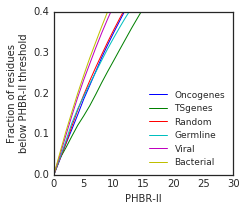

In [13]:
# with 10 cutoff threshold
plt.figure(figsize=(3.5, 3))
for cat in categories:
    plt.plot(np.arange(0, 31, 1), fraction[cat], label=cat)
plt.legend(loc=4)
plt.xlim(0, 30)
plt.ylim(0, 0.4)
plt.ylabel('Fraction of residues\nbelow PHBR-II threshold')
plt.xlabel('PHBR-II')
plt.locator_params(axis='y', nbins=6)
L = plt.legend(loc=4, prop={'size': 9})
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/patient.cdf.all_mutations.pdf')

###Iterations of Random residues

In [21]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.conservative.mut.ClassII.csv', 
                     index_col=0)
conservative_patients = list(df.index)

In [22]:
categories = ['random'+str(i) for i in range(20)]
value_types = []
categories_extended = []
for category in categories:
    df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.TCGA.inclusive.mut.csv'.format(category), 
                     index_col=0)
    values = get_values_from_df(df[conservative_patients])
    value_types.extend(values)
    categories_extended.extend([category]*len(values))
    print category, len(values)

random0 5942000
random1 5942000
random2 5942000
random3 5942000
random4 5942000
random5 5942000
random6 5942000
random7 5942000
random8 5942000
random9 5942000
random10 5942000
random11 5942000
random12 5942000
random13 5942000
random14 5942000
random15 5942000
random16 5942000
random17 5942000
random18 5942000
random19 5942000


In [23]:
len(value_types), len(categories_extended)

(118840000, 118840000)

In [24]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.cancer.TCGA.inclusive.mut.csv',
                 index_col=0)
mutation_counts = pd.DataFrame(df.sum()).reset_index()
mutation_counts.columns = ['mutation', 'count']
driver_mutations = list(mutation_counts[mutation_counts['count'] > 10].mutation)
#driver_mutations = list(mutation_counts.mutation)
print len(driver_mutations)
categories = ['oncogenes', 'tsgenes']
for category in categories:
    # restrict the columns to higher frequency mutations
    df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/{0}.TCGA.inclusive.mut.csv'.format(category),
                     index_col=0)
    #df.set_index('mutation', inplace=True)
    app_restricted_space = [x for x in driver_mutations if x in df.index]
    values = get_values_from_df(df.ix[app_restricted_space, conservative_patients])
    print category, len(values), len([category]*len(values))
    value_types.extend(values)
    categories_extended.extend([category]*len(values))

98
oncogenes 303042 303042
tsgenes 273332 273332


In [25]:
len(value_types), len(categories_extended)

(119416374, 119416374)

In [26]:
plotting = pd.DataFrame({'category': categories_extended,
                         'PHBR': value_types})

In [27]:
all_categories = ['random'+str(i) for i in range(20)] + ['oncogenes', 'tsgenes']

In [30]:
fraction = {}
for cat in all_categories:
    fraction[cat] = []
for x in np.arange(0, 31, 1):
    print x
    for cat in all_categories:
        fraction[cat].append(mean(plotting[plotting.category == cat].PHBR < x))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


random0
random1
random2
random3
random4
random5
random6
random7
random8
random9
random10
random11
random12
random13
random14
random15
random16
random17
random18
random19
oncogenes
tsgenes


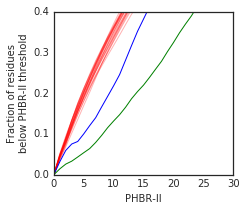

In [31]:
plt.figure(figsize=(3.5, 3))
for cat in all_categories:
    print cat
    if 'random' in cat:
        plt.plot(np.arange(0, 31, 1), fraction[cat], label=cat, color='r', alpha=0.3)
    elif 'ts' in cat:
        plt.plot(np.arange(0, 31, 1), fraction[cat], label=cat, color='g')
    else:
        plt.plot(np.arange(0, 31, 1), fraction[cat], label=cat, color='b')
plt.legend(loc=4)
plt.xlim(0, 30)
plt.ylim(0, 0.4)
plt.ylabel('Fraction of residues\nbelow PHBR-II threshold')
plt.xlabel('PHBR-II')
plt.locator_params(axis='y', nbins=6)
L = plt.legend([])
plt.tight_layout()
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/class_comparison/random_subsets.ecdf.conservative.pdf')